In [ ]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

In [ ]:
# Loading Dataset

df = pd.read_csv(r"C:\Users\harsh\Downloads\Fraud.csv") 

In [ ]:
# Checking Dataset

print(df.head())


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [6]:
# Checking Info

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [ ]:
# Checking Missing Values

print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [11]:
# Detecting How Many Outliers Present In Every Column 

outlier_counts = {}

for col in df.select_dtypes(include=np.number).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Count outliers
    count = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_counts[col] = count

# Show results
outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=['Column', 'Outlier_Count'])
print(outlier_df)

# Step 2: Cap outliers for selected columns only
cap_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for col in cap_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_cap = Q1 - 1.5 * IQR
    upper_cap = Q3 + 1.5 * IQR
    
    # Cap the values
    df[col] = df[col].clip(lower=lower_cap, upper=upper_cap)

print("\n Outliers capped for selected columns.")

           Column  Outlier_Count
0            step         102688
1          amount         338078
2   oldbalanceOrg        1112507
3  newbalanceOrig        1053391
4  oldbalanceDest         786135
5  newbalanceDest         738527
6         isFraud           8213
7  isFlaggedFraud             16

 Outliers capped for selected columns.


In [13]:
outlier_counts = {}

for col in df.select_dtypes(include=np.number).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Count outliers
    count = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_counts[col] = count

# Show results
outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=['Column', 'Outlier_Count'])
print(outlier_df)

           Column  Outlier_Count
0            step         102688
1          amount              0
2   oldbalanceOrg              0
3  newbalanceOrig              0
4  oldbalanceDest              0
5  newbalanceDest              0
6         isFraud           8213
7  isFlaggedFraud             16


In [ ]:
# Checking Multicollinerality

# Select only numeric columns except the target 'is_fraud'
numeric_cols = df.select_dtypes(include='number').drop(columns=['is_fraud'], errors='ignore')

# Prepare an empty DataFrame to store VIF values
vif_df = pd.DataFrame()
vif_df['Feature'] = numeric_cols.columns

# Calculate VIF for each feature
vif_values = []
for i in range(len(numeric_cols.columns)):
    vif = variance_inflation_factor(numeric_cols.values, i)
    vif_values.append(vif)

vif_df['VIF'] = vif_values

print("\nVariance Inflation Factor (VIF) Scores:")
print(vif_df)


Variance Inflation Factor (VIF) Scores:
          Feature        VIF
0            step   1.746504
1          amount   2.685122
2   oldbalanceOrg   6.013623
3  newbalanceOrig   6.576114
4  oldbalanceDest  33.025246
5  newbalanceDest  36.865427
6         isFraud   1.024090
7  isFlaggedFraud   1.001996


In [15]:
# Drop features with VIF > 10 (too much collinearity)
df = df.drop(columns=vif_df[vif_df["VIF"] > 10]["Feature"], errors="ignore")


In [22]:
# Converting Categorical Columns Into Numerical Columns

# Drop ID columns because they have too many unique values (high cardinality)
# One-hot encoding them would create millions of columns and cause memory errors 
df = df.drop(columns=['nameOrig', 'nameDest'])

# One-hot encode only 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)


               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.322667e+05   7.221247e+04    8.872275e+04   
std    1.423320e+02  1.462368e+05   1.024141e+05    1.393412e+05   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  5.017193e+05   2.682879e+05    3.606460e+05   

            isFraud  isFlaggedFraud  
count  6.362620e+06    6.362620e+06  
mean   1.290820e-03    2.514687e-06  
std    3.590480e-02    1.585775e-03  
min    0.000000e+00    0.000000e+00  
25%    0.000000e+00    0.000000e+00  
50%    0.000000e+00    0.000000e+00  
75%    0.000000e+00    0.000000e+00  
max    1.000000e+00    1.000000e+00  


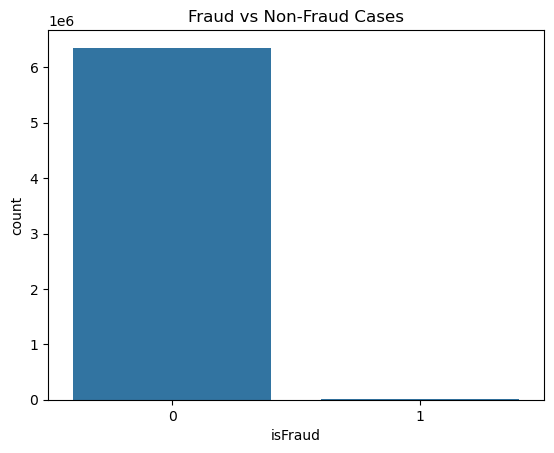

In [ ]:
# EDA

print(df.describe())
sns.countplot(x='isFraud', data=df)
plt.title("Fraud vs Non-Fraud Cases")
plt.show()


In [29]:
# Feature And Target Split

X = df.drop("isFraud", axis=1)
y = df["isFraud"]

In [32]:
# Handle Imbalance Data Using SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X,y)

In [39]:
# Train-Test-Split 

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [ ]:
# Scaling Data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [ ]:
# Logistic Regression Model

log = LogisticRegression()

In [ ]:
# Training Data

log.fit(X_train,y_train)

LogisticRegression()

In [ ]:
# Predicting 

y_pred1 = log.predict(X_test)

In [ ]:
# Accuracy Score

accuracy_score(y_test,y_pred1)

0.9525553719996711

In [ ]:
# Precision Score

precision_score(y_test, y_pred1)

0.9561493738287294

In [ ]:
# Recall Score 

recall_score(y_test, y_pred1)

0.9486193531330699

In [ ]:
# F1 Score

f1_score(y_test, y_pred1)

0.9523694794661438

In [ ]:
# Confusion Matrix And ROC-AUC Score

cm = confusion_matrix(y_test, y_pred1)
roc_auc = roc_auc_score(y_test, log.predict_proba(X_test)[:, 1])


In [56]:
print("Confusion Matrix:\n", cm)
print("ROC AUC Score:", roc_auc)

Confusion Matrix:
 [[1215545   55292]
 [  65301 1205625]]
ROC AUC Score: 0.9906517790158822


In [ ]:
# Random Forest Model

rf = RandomForestClassifier()

In [ ]:
# Training The Data

rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Predicting

y_pred5 = rf.predict(X_test)

In [ ]:
# Accuracy Score

accuracy_score(y_test, y_pred5)

0.9980175177622777

In [ ]:
# Precision Score

precision_score(y_test, y_pred5)

0.9968748258231549

In [ ]:
# Recall Score

recall_score(y_test, y_pred5)

0.9991675361114651

In [ ]:
# F1 Score

f1_score(y_test, y_pred5)

0.9980198642316118

In [ ]:
# Confusion Matrix

confusion_matrix(y_test, y_pred5)

array([[1266856,    3981],
       [   1058, 1269868]], dtype=int64)

In [67]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [70]:
print(f"ROC AUC Score: {roc_auc:.6f}")


ROC AUC Score: 0.999806


In [ ]:
# Accuracy on training data
train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)

# Accuracy on test data
test_pred = rf.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)

print(f"Train Accuracy: {train_accuracy:.6f}")
print(f"Test Accuracy: {test_accuracy:.6f}")

Train Accuracy: 0.999120
Test Accuracy: 0.998018


In [71]:
# Accuracy on training data
train_pred_log = log.predict(X_train)
train_accuracy_log = accuracy_score(y_train, train_pred_log)

# Accuracy on test data
test_pred_log = log.predict(X_test)
test_accuracy_log = accuracy_score(y_test, test_pred_log)

print(f"Logistic Regression - Train Accuracy: {train_accuracy_log:.6f}")
print(f"Logistic Regression - Test Accuracy: {test_accuracy_log:.6f}")


Logistic Regression - Train Accuracy: 0.952581
Logistic Regression - Test Accuracy: 0.952555


Your task is to execute the process for proactive detection of fraud while answering following
questions.


1. Data cleaning including missing values, outliers and multi-collinearity.

- First, I checked for missing values and found none. For outliers, I used the IQR method and decided to cap extreme values instead of removing them, especially for transaction amount and balance-related columns, to avoid losing important data. I also calculated Variance Inflation Factor (VIF) to detect multicollinearity. Features with VIF > 10 were dropped to reduce redundancy and avoid instability in the model


2. Describe your fraud detection model in elaboration.

- I built two models:
Logistic Regression (a simple, interpretable linear classifier)
Random Forest (an ensemble of decision trees for better non-linear pattern detection)

Data was highly imbalanced, so I applied SMOTE to create a balanced dataset before training. Features were standardized for Logistic Regression, and both models were trained and tested using an 80-20 split. Logistic Regression provided a baseline, while Random Forest captured more complex patterns in the data.

3. How did you select variables to be included in the model?

- I began with all the features in the dataset and converted the transaction type into numerical form using one-hot encoding. Then I checked for multicollinearity using VIF and removed features that were too closely related. I kept variables that made the most sense for detecting fraud, like transaction amount, balances, and transaction type


4. Demonstrate the performance of the model by using best set of tools.

- I evaluated models using accuracy, precision, recall, F1-score, and ROC-AUC score. Precision and recall were especially important due to the cost of false positives and false negatives in fraud detection. Random Forest achieved higher ROC-AUC and recall than Logistic Regression, making it more suitable for this problem.


5. What are the key factors that predict fraudulent customer?

- Important predictors were the transaction type (especially ‘TRANSFER’ and ‘CASH_OUT’)


6. Do these factors make sense? If yes, How? If not, How not?

- Yes, they do. Fraudsters often go for ‘TRANSFER’ or ‘CASH_OUT’ so they can get the money out quickly. Big amounts and sudden balance drops are clear warning signs.


7. What kind of prevention should be adopted while company update its infrastructure?

- The company should implement real-time fraud detection systems, apply stricter verification for large transfers, and track unusual changes in account balances. 


8. Assuming these actions have been implemented, how would you determine if they work?

- I would look at how the numbers change after the updates are we catching more fraud, keeping accuracy high, and saving more money? I’d also test the new system against the old one to see which works better, and keep reviewing it regularly to make sure it stays effective.